In [10]:
import requests
from bs4 import BeautifulSoup
import random
import string
import zipfile
import ast
import collections
from collections import Counter

import pandas as pd
import numpy as np
import wikipedia
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import stanza
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
stop_words = stopwords.words('english')

# Data Collection

In [3]:
def create_dataset(src, n):
    """
    Creates a dataset of n sentences from a given source.

    src: str, either a wikipedia url or path to a zip file (ending in .zip)
    n: int, number of sentences to extract
    Return: list of strings
    """
    if "wikipedia.org" in src:
        dataset = data_from_url(src, n)
    elif src[-4:] == '.zip' and src[:4] != 'http':
      dataset = data_from_archive(n)
    else:
        raise ValueError("Invalid source specified. Please choose 'archive' or 'url'.")
    return dataset

In [4]:
def data_from_archive(path_to_zip_file, n):
    '''
    Code to retrieve data from a zip file

    path_to_zip_file: str, path to a zip file, ending in .zip
    n: int, number of sentences to extract
    Return: list of strings
    '''
    dataset = []
    count = 0

    with zipfile.ZipFile(path_to_zip_file, 'r') as f:
      for name in f.namelist():
          data = f.read(name)
          if count < n:
            dataset.append(data)
            count += 1
          else:
            break

    return dataset

def data_from_url(path_to_url, n):
    '''
    Code to retrieve data from a wikipedia url

    path_to_url: str, url to a wikipedia page
    n: int, number of sentences to extract
    Return: list of strings
    '''  
    dataset = []
    count = 0

    page = wikipedia.page(path_to_url)
    content = page.content
    dataset.append(content)
    
    all_links = page.links
    for link in all_links:
      if count < n-1:
        try:
          page = wikipedia.page(title=link)
          content = page.content
          dataset.append(content)
          count += 1
        except: pass
      else:
        break
    
    return dataset

In [5]:
src = "https://en.wikipedia.org/wiki/List_of_philosophers_born_in_the_15th_and_16th_centuries"
n = 50

# Extract data
dataset = create_dataset(src, n)

/Users/hzh/miniconda3/envs/data/lib/python3.9/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/hzh/miniconda3/envs/data/lib/python3.9/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [11]:
df_dataset = pd.DataFrame(dataset, columns=['texts'])
df_dataset.to_csv('part2_dataset.csv', index=False)

# Sentence segmentation

Here we will compare two libraries: Stanza and Spacy. The code will provide with following information:
* Total number of sentences in the parsed data
* Number of sentences recognized by Spacy
* Number of sentences recognized by Stanza
* Number of shared sentences

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/hzh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# if not downloaded:
#!python -m spacy download en_core_web_sm

In [4]:
df_dataset = pd.read_csv("part2_dataset.csv")
df_dataset.head()

,texts
0,Some notable French Huguenots or people with F...
1,Abel Boyer (1667? – 16 November 1729) was a Fr...
2,"Abolitionism, or the abolitionist movement, is..."
3,"In the United States, abolitionism, the moveme..."
4,Abraham Bosse (c. 1604 – 14 February 1676) was...


In [5]:
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize')
nlp_spacy = spacy.load('en_core_web_sm')

2023-05-14 20:18:58 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-05-14 20:18:58 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-05-14 20:18:58 INFO: Using device: cpu
2023-05-14 20:18:58 INFO: Loading: tokenize
2023-05-14 20:18:58 INFO: Done loading processors!


In [7]:
def sentence_segmentation(df):
    '''
    Perform sentence segmentation,
    calculate the number of sentences in the text according to stanza and spacy,
    find the shared sentences between stanza and spacy and the unique sentences for each.

    df: dataframe

    Return: dataframe
    '''
    # sentence segmentation
    df['sentences_stanza'] = df['texts'].apply(lambda x: [sentence.text for sentence in nlp_stanza(x).sentences])
    df['sentences_spacy'] = df['texts'].apply(lambda x: [sentence.text for sentence in nlp_spacy(x).sents])

    # number of sentences
    df['num_sentences_stanza'] = df['sentences_stanza'].apply(len)
    df['num_sentences_spacy'] = df['sentences_spacy'].apply(len)
    
    # shared and unique sentences
    shared_sentences = set()
    unique_sentences_stanza = set()
    unique_sentences_spacy = set()
    
    for i in range(len(df)):
        shared_sentences.update(set(df['sentences_stanza'][i]).intersection(set(df['sentences_spacy'][i])))
        unique_sentences_stanza.update(set(df['sentences_stanza'][i]).difference(set(df['sentences_spacy'][i])))
        unique_sentences_spacy.update(set(df['sentences_spacy'][i]).difference(set(df['sentences_stanza'][i])))
    
    df['unique_sent_stanza'] = pd.Series(list(unique_sentences_stanza))
    df['unique_sent_spacy'] = pd.Series(list(unique_sentences_spacy))  
    
    # save the results
    df_shared_sents = pd.DataFrame({"shared_sentences": list(shared_sentences)})
    df_shared_sents.to_csv("shared_sentences.csv", index=False)
    df.to_csv("part2_segmented_dataset.csv", index=False)
    
    # print the results
    print("Total number of sentences in the dataset: ", df['num_sentences_stanza'].sum() + df['num_sentences_spacy'].sum())
    print("Number of sentences in the text according to stanza: ", df['num_sentences_stanza'].sum())
    print("Number of sentences in the text according to spacy: ", df['num_sentences_spacy'].sum())
    print("Number of shared sentences: ", len(shared_sentences))
    print("Number of unique sentences for stanza: ", len(unique_sentences_stanza))
    print("Number of unique sentences for spacy: ", len(unique_sentences_spacy))
        
    return df_shared_sents

In [8]:
df_shared_sents = sentence_segmentation(df_dataset)

Total number of sentences in the dataset:  31281
Number of sentences in the text according to stanza:  15943
Number of sentences in the text according to spacy:  15338
Number of shared sentences:  4740
Number of unique sentences for stanza:  3786
Number of unique sentences for spacy:  3406


In [9]:
df_shared_sents.head()

,shared_sentences
0,"In his first Tariff Bill in January 1790, Hami..."
1,"Passed on 10 May 2001, the Taubira law officia..."
2,"The army was formed on November 20, 1862, when..."
3,Lacking the technology and infrastructure to b...
4,"White Loyalists transported 15,000 enslaved bl..."


# Tokenization

In this part we will compare tokens which appear firtst in texts without segmentation and then with segmentation.

## SharedTokensNoSentences

In [8]:
def preprocess(tokens_list, remove_stop_words=True):
    
    """ 
    Removes non-ASCII chars, perform tokenization, lowercase the tokens,
    delete stopwords, punctuation and non-alphabetical characters,
    and convert tokens to normal form.

    tokens_list: list, of strings
    remove_stop_words: bool, whether to remove stop words or not

    Return: list, of strings
    """
    tokens = [token.lower() for token in tokens_list] # lowercase
    tokens = [token for token in tokens if token not in string.punctuation] # remove punctuation
    tokens = [token for token in tokens if token.isalpha()] # remove non-alphabetical characters
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words] # remove stopwords

    lemmatizer = WordNetLemmatizer()  
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # convert to normal form

    return tokens

In [9]:
df_processed = pd.read_csv("part2_processed_dataset.csv")
df_processed.head(5)

,texts,sentences_stanza,sentences_spacy,num_sentences_stanza,num_sentences_spacy,unique_sent_stanza,unique_sent_spacy
0,Some notable French Huguenots or people with F...,['Some notable French Huguenots or people with...,['Some notable French Huguenots or people with...,1642,1630,"Marthe de Rocoulle (1659–1741), Huguenot gover...","Franklin D. Roosevelt, 32nd President of the U..."
1,Abel Boyer (1667? – 16 November 1729) was a Fr...,['Abel Boyer (1667? – 16 November 1729) was a ...,['Abel Boyer (1667? – 16 November 1729) was a ...,54,51,One of the principal sources of revenue Hamilt...,In March Galland was ordered to report to Jagd...
2,"Abolitionism, or the abolitionist movement, is...","['Abolitionism, or the abolitionist movement, ...","['Abolitionism, or the abolitionist movement, ...",332,302,== Politics ==\nLincoln has appeared in a vide...,"Anthony Boureau, gunsmith in America.\n"
3,"In the United States, abolitionism, the moveme...","['In the United States, abolitionism, the move...","['In the United States, abolitionism, the move...",545,518,"Guillaume de Clermont, pastor, regional synod ...","Pierre Encontre, pastor.\n"
4,Abraham Bosse (c. 1604 – 14 February 1676) was...,['Abraham Bosse (c.\u20091604 – 14 February 16...,['Abraham Bosse (c.\u20091604 – 14 February 16...,65,75,"John Rawstorne Papillon, Anglican clergyman, d...",It tends to reintegrate the historiographies o...


In [ ]:
# load models
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize')
nlp_spacy = spacy.load('en_core_web_sm')

In [10]:
def tokenization_before_segmentation(df):
    """
    Perform tokenization before segmentation,
    calculate the token occurence for stanza and spacy and the shared tokens between them.

    df: dataframe

    Return: dataframe
    """
    # tokenize
    df['tokens_stanza'] = df['texts'].apply(lambda x: [token.text for sentence in nlp_stanza(x).sentences for token in sentence.tokens])
    df['tokens_spacy'] = df['texts'].apply(lambda x: [token.text for token in nlp_spacy(x)])
    
    # preprocess the tokens
    df['tokens_stanza'] = df['tokens_stanza'].apply(preprocess) 
    df['tokens_spacy'] = df['tokens_spacy'].apply(preprocess)
    
    # tokens occurence for each library
    df["tokens_occurence_stanza"] = df["tokens_stanza"].apply(lambda x: collections.Counter(x)) 
    df["tokens_occurence_spacy"] = df["tokens_spacy"].apply(lambda x: collections.Counter(x))
    
    # vocab of tokens for each library
    vocab_stanza = set(token for tokens in df['tokens_stanza'] for token in tokens)
    vocab_spacy = set(token for tokens in df['tokens_spacy'] for token in tokens)
    
    # tokens shared by both vocabularies
    both_vocab_tokens = vocab_stanza.intersection(vocab_spacy)
    
    # all tokens in the dataset
    common_tokens_stanza = vocab_stanza.union(vocab_spacy)
    
    # tokens recognized by only one library
    only_spacy_tokens = vocab_spacy.difference(vocab_stanza) 
    only_stanza_tokens = vocab_stanza.difference(vocab_spacy) 
    
    # print the results
    print("================" * 10)
    print("Number of tokens in the vocabulary of stanza: ", len(vocab_stanza))
    print("STANZA TOKENS\n", vocab_stanza) 
    
    print("================" * 10)
    print("Number of tokens in the vocabulary of spacy: ", len(vocab_spacy))
    print("SPACY TOKENS\n", vocab_spacy)
    
    print("================" * 10)
    print("Number of tokens in the vocabulary of both libraries: ", len(both_vocab_tokens))
    print("Tokens in the vocabulary of both libraries\n", both_vocab_tokens)
    
    print("================" * 10)
    print("Number of all tokens: ", len(common_tokens_stanza))
    print("All tokens\n", common_tokens_stanza)
    
    print("================" * 10)
    print("Number of tokens that only in the vocabulary of stanza: ", len(only_stanza_tokens))
    print("UNIQUE FOR STANZA", only_stanza_tokens)
    
    print("================" * 10)
    print("Number of tokens that only in the vocabulary of spacy: ", len(only_spacy_tokens))
    print("UNIQUE FOR SPACY", only_spacy_tokens)
    
    print("================" * 10)
    print("Top 50 most common tokens for stanza", df["tokens_occurence_stanza"].sum().most_common(50))
    
    print("================" * 10)
    print("Top 50 most common tokens for spacy", df["tokens_occurence_spacy"].sum().most_common(50))
    
    return df

In [11]:
df_before_seg = tokenization_before_segmentation(df_processed)
df_before_seg.to_csv("tokenization_before_segmentation.csv", index=False)

2023-05-14 19:53:59 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-05-14 19:53:59 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-05-14 19:53:59 INFO: Using device: cpu
2023-05-14 19:53:59 INFO: Loading: tokenize
2023-05-14 19:53:59 INFO: Done loading processors!


Number of tokens in the vocabulary of stanza:  15382
STANZA TOKENS
 {'iturrigaray', 'informally', 'pivotal', 'counterbalance', 'peasant', 'madrid', 'manakin', 'okl', 'enlightened', 'living', 'collaborated', 'danbury', 'shared', 'georgina', 'prosecute', 'bonet', 'bonnell', 'tyrant', 'blumhardt', 'isolating', 'colonization', 'bastille', 'fresco', 'sculptor', 'henschel', 'need', 'handbill', 'shot', 'mifflin', 'featuring', 'cyd', 'defines', 'associate', 'back', 'appears', 'barrack', 'evade', 'salle', 'maison', 'chaos', 'temporary', 'vendome', 'eighteenth', 'analytica', 'allowance', 'vermeil', 'wilmer', 'repeating', 'chardonne', 'topped', 'fun', 'likewise', 'stipend', 'deleted', 'marauder', 'soviet', 'confounded', 'veines', 'throw', 'avanturiers', 'florence', 'liminal', 'deliberation', 'homefront', 'kind', 'spotsylvania', 'merche', 'denounce', 'imagery', 'albany', 'jose', 'content', 'tragedy', 'liberalizing', 'liverpool', 'cazenove', 'healing', 'thence', 'lecerf', 'socialized', 'boy', 'gera

## SharedTokensInSentences

Now we will work with shared segmented sentences.

In [12]:
# if starting from here:
# run Sentence Segmentation first

# df_shared_sents = pd.read_csv("shared_sentences.csv")
# shared_sent_df.head()

,shared_sentences
0,"Cooper again adopted a leaner, cleaner sound f..."
1,"A friend, Major Rheital, kept the doctors repo..."
2,"The Symposium was well attended, but Soyer was..."
3,"To restore the empire, the British had to defe..."
4,The terms were confidential since several conf...


In [5]:
def tokenize_after_segmentation(shared_sent_df):
    
    nlp1 = stanza.Pipeline(lang='en', processors='tokenize')
    nlp2 = spacy.load('en_core_web_sm')
    
    shared_sent_df['tokens_stanza'] = shared_sent_df['shared_sentences'].apply(lambda x: [token.text for sentence in nlp1(x).sentences for token in sentence.tokens])
    shared_sent_df['tokens_spacy'] = shared_sent_df['shared_sentences'].apply(lambda x: [token.text for token in nlp2(x)])
    
    shared_sent_df["cleaned_tokens_stanza"] = shared_sent_df["tokens_stanza"].apply(lambda x: preprocess(x))
    shared_sent_df["cleaned_tokens_spacy"] = shared_sent_df["tokens_spacy"].apply(lambda x: preprocess(x))
    
    shared_sent_df["tokens_occurence_stanza"] = shared_sent_df["cleaned_tokens_stanza"].apply(lambda x: collections.Counter(x))
    shared_sent_df["tokens_occurence_spacy"] = shared_sent_df["cleaned_tokens_spacy"].apply(lambda x: collections.Counter(x))
    

     # creating vocabularies of unique tokens for each library
    vocab_stanza = set(token for tokens in shared_sent_df['tokens_stanza'] for token in tokens)
    vocab_spacy = set(token for tokens in shared_sent_df['tokens_spacy'] for token in tokens)
    
    # tokens which simalteneously present in both vocabularies
    both_vocab_tokens = vocab_stanza.intersection(vocab_spacy)
    
    # all tokens which present in both vocabularies
    common_tokens_stanza = vocab_stanza.union(vocab_spacy)
    
    only_spacy_tokens = vocab_spacy.difference(vocab_stanza) # reconized only by spacy
    only_stanza_tokens = vocab_stanza.difference(vocab_spacy) # # reconized only by stanza
    
    common_token_occurrences = shared_sent_df["tokens_occurence_stanza"].sum() & shared_sent_df["tokens_occurence_stanza"].sum() # all token occurrences 
    
    all_counts_stanza = sum(shared_sent_df["tokens_occurence_stanza"], Counter())
    all_counts_spacy = sum(shared_sent_df["tokens_occurence_spacy"], Counter())
        
    print("================" * 10)
    print("Number of tokens in the vocabulary of stanza: ", len(vocab_stanza))
    print("STANZA TOKENS\n", vocab_stanza) 
    
    print("================" * 10)
    print("Number of tokens in the vocabulary of spacy: ", len(vocab_spacy))
    print("SPACY TOKENS\n", vocab_spacy)
    
    print("================" * 10)
    print("Number of tokens in the vocabulary of both libraries: ", len(both_vocab_tokens))
    print("Tokens in the vocabulary of both libraries\n", both_vocab_tokens)
    
    print("================" * 10)
    print("Number of all tokens: ", len(common_tokens_stanza))
    print("All tokens\n", common_tokens_stanza)
    
    print("================" * 10)
    print("Number of tokens that only in the vocabulary of stanza: ", len(only_stanza_tokens))
    print("UNIQUE FOR STANZA", only_stanza_tokens)
    
    print("================" * 10)
    print("Number of tokens that only in the vocabulary of spacy: ", len(only_spacy_tokens))
    print("UNIQUE FOR SPACY", only_spacy_tokens)
    
    print("================" * 10)
    print("Top 50 most common tokens recognized by both stanza and spacy", common_token_occurrences.most_common(50))

    print("================" * 10)
    print("Top 50 most common tokens for stanza", all_counts_stanza)
    
    print("================" * 10)
    print("Top 50 most common tokens for spacy", all_counts_spacy)
    
    
    wordcloud_phil = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(dict(all_counts_stanza.most_common(30)))
    wordcloud_phys = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate_from_frequencies(dict(all_counts_spacy.most_common(30)))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    ax1.imshow(wordcloud_phil)
    ax1.axis("off")
    ax1.set_title("Top 50 common words recognized by Stanza")

    ax2.imshow(wordcloud_phys)
    ax2.axis("off")
    ax2.set_title("Top 50 common words recognized by Spacy")

    plt.tight_layout()
    plt.show()
    
    shared_sent_df.to_csv("tokenization_after_segmentation.csv", index=False)
    return shared_sent_df

2023-05-15 21:23:33 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-15 21:23:33 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-05-15 21:23:33 INFO: Using device: cpu
2023-05-15 21:23:33 INFO: Loading: tokenize
2023-05-15 21:23:33 INFO: Done loading processors!


Number of tokens in the vocabulary of stanza:  14893
STANZA TOKENS
 {'Hogarth', 'surrender', 'perpendicular', 'Lay', 'facto', 'charcoal', 'MG', 'abolitionism', 'philosopher', 'Urban', 'die', '38', 'recording', 'Gen.', 'polymath', 'lack', 'experience', 'veteran', 'kept', 'smooth', 'grievance', 'advisors', 'Pop', 'extortion', 'houses', 'Pickett', 'work', 'bisecting', 'Dieu', 'Gunther', 'employed', 'friendly', 'editorial', 'alert', 'ETO', 'meanwhile', 'Rescue', 'printing', 'Identifying', 'policy', 'Harlem', 'criticized', 'persists', 'marketplace', 'acquitted', 'following', 'personally', 'probate', 'Antonescu', 'mystic', 'treasurer', 'plenty', 'viewing', 'revised', 'use', 'blamed', 'Help', 'pertinent', 'plummeted', 'suppressing', 'sponsored', 'Enfants', 'Paoli', 'obliged', 'noticing', 'Covenant', 'dislike', 'holistically', 'excess', 'fake', 'attempts', 'scum', '23–36', 'send', 'fallen', 'Dutch', 'chairman', 'Morale', 'Dunn', 'Hildebrand', 'ideology', 'downtown', 'advent', 'defining', 'unsk

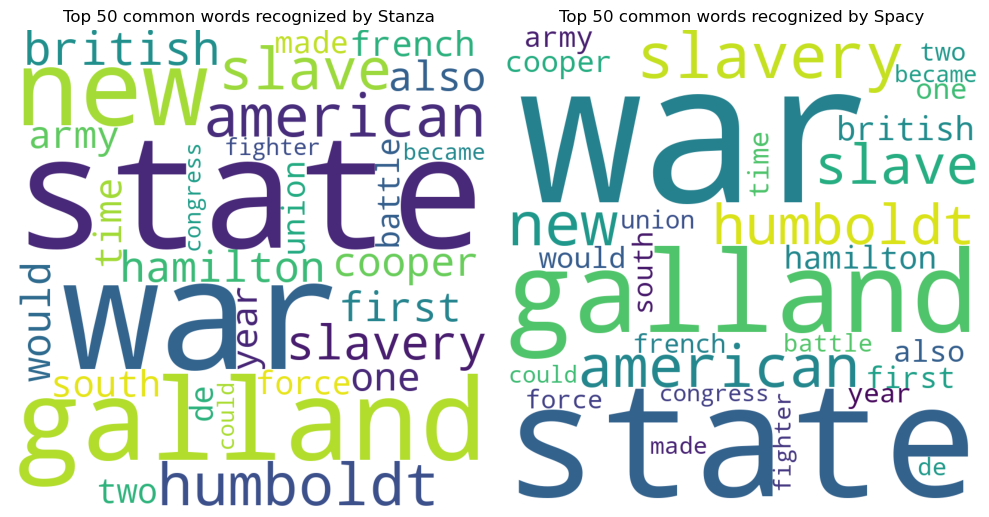

In [11]:
df_after_seg = tokenize_after_segmentation(df_shared_sents)

# POS tagging

In [15]:
# if starting from here:
# run the two cells above first

# df_after_seg = pd.read_csv('tokenization_after_segmentation.csv')
# df_after_seg.head()

,shared_sentences,tokens_stanza,tokens_spacy,cleaned_tokens_stanza,cleaned_tokens_spacy,tokens_occurence_stanza,tokens_occurence_spacy
0,"Cooper again adopted a leaner, cleaner sound f...","['Cooper', 'again', 'adopted', 'a', 'leaner', ...","['Cooper', 'again', 'adopted', 'a', 'leaner', ...","['cooper', 'adopted', 'leaner', 'cleaner', 'so...","['cooper', 'adopted', 'leaner', 'cleaner', 'so...","Counter({'cooper': 2, 'adopted': 1, 'leaner': ...","Counter({'cooper': 2, 'adopted': 1, 'leaner': ..."
1,"A friend, Major Rheital, kept the doctors repo...","['A', 'friend', ',', 'Major', 'Rheital', ',', ...","['A', 'friend', ',', 'Major', 'Rheital', ',', ...","['friend', 'major', 'rheital', 'kept', 'doctor...","['friend', 'major', 'rheital', 'kept', 'doctor...","Counter({'friend': 1, 'major': 1, 'rheital': 1...","Counter({'friend': 1, 'major': 1, 'rheital': 1..."
2,"The Symposium was well attended, but Soyer was...","['The', 'Symposium', 'was', 'well', 'attended'...","['The', 'Symposium', 'was', 'well', 'attended'...","['symposium', 'well', 'attended', 'soyer', 'go...","['symposium', 'well', 'attended', 'soyer', 'go...","Counter({'symposium': 1, 'well': 1, 'attended'...","Counter({'symposium': 1, 'well': 1, 'attended'..."
3,"To restore the empire, the British had to defe...","['To', 'restore', 'the', 'empire', ',', 'the',...","['To', 'restore', 'the', 'empire', ',', 'the',...","['restore', 'empire', 'british', 'defeat', 'co...","['restore', 'empire', 'british', 'defeat', 'co...","Counter({'restore': 1, 'empire': 1, 'british':...","Counter({'restore': 1, 'empire': 1, 'british':..."
4,The terms were confidential since several conf...,"['The', 'terms', 'were', 'confidential', 'sinc...","['The', 'terms', 'were', 'confidential', 'sinc...","['term', 'confidential', 'since', 'several', '...","['term', 'confidential', 'since', 'several', '...","Counter({'term': 1, 'confidential': 1, 'since'...","Counter({'term': 1, 'confidential': 1, 'since'..."


In [16]:
# converting string to list
df_after_seg['cleaned_tokens_stanza'] = df_after_seg['cleaned_tokens_stanza'].apply(ast.literal_eval)
df_after_seg['cleaned_tokens_spacy'] = df_after_seg['cleaned_tokens_spacy'].apply(ast.literal_eval)

In [18]:
# creating vocabularies of unique tokens for each library
vocab_stanza = set(token for tokens in df_after_seg['cleaned_tokens_stanza'] for token in tokens)
vocab_spacy = set(token for tokens in df_after_seg['cleaned_tokens_spacy'] for token in tokens)

# tokens which simalteneously present in both vocabularies
SharedTokenInSentences = vocab_stanza.intersection(vocab_spacy)

# creating dataframe for storing pos tags
df_pos = pd.DataFrame(columns=['token', 'stanza_pos', 'spacy_pos'])
df_pos['token'] = list(SharedTokenInSentences)

In [19]:
# pos tagging using stanza
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize,pos')
stanza_doc = df_pos['token'].apply(nlp_stanza)
df_pos['stanza_pos'] = [token.sentences[0].words[0].upos for token in stanza_doc]

2023-05-14 20:02:45 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-05-14 20:02:46 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-05-14 20:02:46 INFO: Using device: cpu
2023-05-14 20:02:46 INFO: Loading: tokenize
2023-05-14 20:02:46 INFO: Loading: pos
2023-05-14 20:02:46 INFO: Done loading processors!


In [20]:
# pos tagging using spacy
nlp_spacy = spacy.load('en_core_web_sm')
df_pos['spacy_pos'] = [t.pos_ for token in df_pos['token'].apply(nlp_spacy) for t in token]

In [16]:
df_pos.head()

,token,stanza_pos,spacy_pos
0,thrill,NOUN,NOUN
1,protestors,NOUN,NOUN
2,horen,NOUN,NOUN
3,act,VERB,VERB
4,wonder,VERB,VERB


In [17]:
print(f"Number of tokens in the dataset: {df_pos.shape[0]}")
print(f"Number of times the token is assigned the same UPOS by both libraries: {df_pos[df_pos['stanza_pos'] == df_pos['spacy_pos']].shape[0]}")
print(f"Ratio of the times the token is assigned the same UPOS by both libraries: {df_pos[df_pos['stanza_pos'] == df_pos['spacy_pos']].shape[0] / df_pos.shape[0]}")

Number of tokens in the dataset: 10984
Number of times the token is assigned the same UPOS by both libraries: 7501
Ratio of the times the token is assigned the same UPOS by both libraries: 0.6829024034959942


In [18]:
# list of pos tags in each library's results
upos_spacy = df_pos['spacy_pos'].unique()
upos_stanza = df_pos['stanza_pos'].unique()

In [19]:
def frequency_mapping(lib, upos_list):
    '''
    Map frequency of UPOS tags in one library to the other library
    lib: str, 'spacy' or 'stanza'
    upos_list: list of UPOS tags in the library
    return: dict, mapping of frequencies
    '''
    if lib == 'spacy':
        other_lib = 'stanza'
    else:
        other_lib = 'spacy'

    print(f"Frequencies of {lib} UPOS tags")
    mapping = {}
    for tag in upos_list:
        print(f"\nFor all tokens labelled {tag} in {lib}:")

        mapping[tag] = {}
        sub_df = df_pos[df_pos[f'{lib}_pos'] == tag]
        other_lib_tag_list = df_pos[df_pos[f'{lib}_pos'] == tag][f'{other_lib}_pos'].unique()

        for other_tag in other_lib_tag_list:
            mapping[tag][other_tag] = len(sub_df[sub_df[f'{other_lib}_pos'] == other_tag]) / len(sub_df) * 100
        for key, value in mapping[tag].items():
            print(f"{key}: {value:.2f}%", end=", ")

    return mapping

In [20]:
mapping_spacy = frequency_mapping('spacy', upos_spacy)

Frequencies of spacy UPOS tags

For all tokens labelled NOUN in spacy:
NOUN: 71.70%, PROPN: 22.50%, VERB: 2.26%, ADJ: 2.92%, X: 0.32%, INTJ: 0.22%, ADV: 0.07%, NUM: 0.02%, 
For all tokens labelled VERB in spacy:
VERB: 59.82%, PROPN: 11.20%, ADJ: 5.87%, NOUN: 22.79%, INTJ: 0.09%, X: 0.15%, PUNCT: 0.03%, SYM: 0.03%, ADV: 0.03%, 
For all tokens labelled PROPN in spacy:
PROPN: 72.25%, INTJ: 0.92%, NOUN: 20.63%, ADJ: 4.30%, VERB: 1.29%, X: 0.37%, ADV: 0.18%, PUNCT: 0.06%, 
For all tokens labelled ADJ in spacy:
ADJ: 79.70%, NOUN: 8.97%, PROPN: 8.80%, VERB: 1.48%, ADV: 0.87%, INTJ: 0.17%, 
For all tokens labelled INTJ in spacy:
PROPN: 40.00%, INTJ: 28.00%, NOUN: 28.00%, ADJ: 4.00%, 
For all tokens labelled ADP in spacy:
ADP: 20.00%, ADV: 42.50%, NOUN: 5.00%, PROPN: 30.00%, ADJ: 2.50%, 
For all tokens labelled ADV in spacy:
ADV: 68.75%, CCONJ: 0.20%, PROPN: 13.48%, ADJ: 10.35%, NOUN: 6.25%, INTJ: 0.78%, SYM: 0.20%, 
For all tokens labelled PRON in spacy:
PRON: 57.89%, NOUN: 15.79%, PROPN: 15.7

In [21]:
mapping_stanza = frequency_mapping('stanza', upos_stanza)

Frequencies of stanza UPOS tags

For all tokens labelled NOUN in stanza:
NOUN: 69.95%, PROPN: 7.96%, VERB: 18.42%, ADJ: 2.44%, ADP: 0.05%, PRON: 0.07%, ADV: 0.76%, X: 0.12%, NUM: 0.02%, INTJ: 0.17%, PUNCT: 0.05%, 
For all tokens labelled VERB in stanza:
VERB: 93.92%, NOUN: 4.28%, PROPN: 0.97%, ADJ: 0.78%, X: 0.05%, 
For all tokens labelled PROPN in stanza:
PROPN: 43.67%, NOUN: 34.36%, VERB: 14.17%, INTJ: 0.37%, ADJ: 3.75%, ADV: 2.56%, X: 0.37%, ADP: 0.45%, PUNCT: 0.11%, PRON: 0.11%, CCONJ: 0.04%, AUX: 0.04%, 
For all tokens labelled ADJ in stanza:
ADJ: 67.18%, VERB: 14.68%, PROPN: 5.14%, NOUN: 8.81%, ADV: 3.89%, X: 0.15%, ADP: 0.07%, INTJ: 0.07%, 
For all tokens labelled INTJ in stanza:
PROPN: 35.71%, INTJ: 16.67%, VERB: 7.14%, NOUN: 21.43%, ADJ: 4.76%, ADV: 9.52%, PUNCT: 2.38%, X: 2.38%, 
For all tokens labelled ADP in stanza:
ADP: 61.54%, SCONJ: 38.46%, 
For all tokens labelled ADV in stanza:
ADP: 4.31%, ADV: 89.34%, ADJ: 2.54%, PROPN: 0.76%, SCONJ: 1.52%, X: 0.25%, NOUN: 0.76%, AUX:

## Visualization

In [22]:
spacy2stanza = pd.DataFrame(mapping_spacy)
stanza2spacy = pd.DataFrame(mapping_stanza)

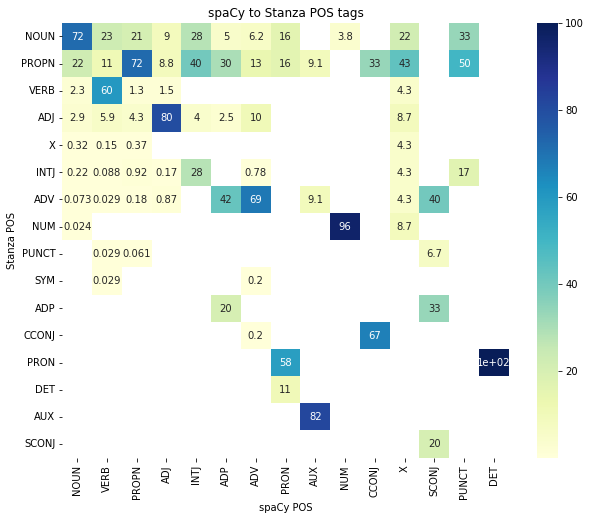

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(spacy2stanza, annot=True, cmap='YlGnBu')
plt.title('spaCy to Stanza POS tags')
plt.xlabel('spaCy POS')
plt.ylabel('Stanza POS')
plt.show()

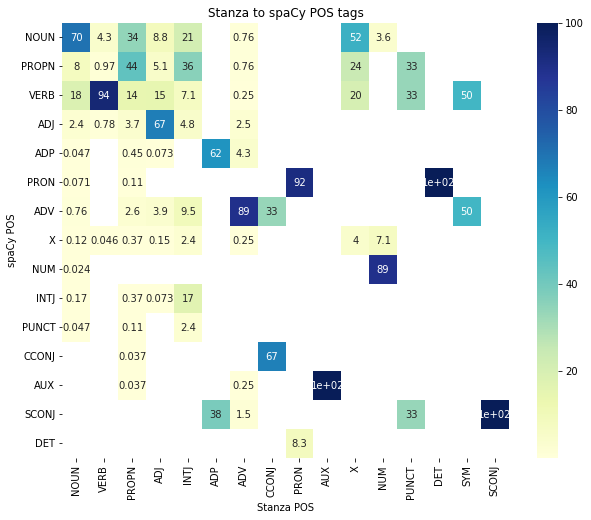

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(stanza2spacy, annot=True, cmap='YlGnBu')
plt.title('Stanza to spaCy POS tags')
plt.xlabel('Stanza POS')
plt.ylabel('spaCy POS')
plt.show()